In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import hstack
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from IPython.display import display_html

c:\projects\foodapp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
c:\projects\foodapp\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
PATH_TO_DATA = '../../data/'
SEED = 17
times = ['time%s' % i for i in range(1, 11)]

"Bag of sites" baseline

In [6]:
def prepare_sparse_features(path_to_train, path_to_test, path_to_site_dict, vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    # sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # read site -> id mapping
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create inverse dict id -> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # transform data for fed into TfidfVEctorizer
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [7]:
%%time
X_train_sites, X_test_sites, y_train, vectorizer, train_times, test_times = prepare_sparse_features(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={
        'ngram_range': (1, 5),
        'max_features': 50000,
        'tokenizer': lambda s: s.split()
    }
)

Wall time: 26.8 s


In [5]:
X_train_sites.shape, X_test_sites.shape

((253561, 50000), (82797, 50000))

In [6]:
vectorizer.get_feature_names()[:10]

['0.academia-assets.com',
 '0.docs.google.com',
 '0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.docs.google.com 0.docs.google.com',
 '0.docs.google.com 0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.docs.google.com apis.google.com',
 '0.docs.google.com 0.docs.google.com docs.google.com',
 '0.docs.google.com 0.drive.google.com',
 '0.docs.google.com 0.drive.google.com 0.docs.google.com']

In [7]:
vectorizer.get_feature_names()[10000:10010]

['de-img3.ask.fm',
 'de-img4.ask.fm',
 'de.tynt.com',
 'de.tynt.com api.adyoulike.com',
 'de.tynt.com api.adyoulike.com syndication.twitter.com',
 'de.tynt.com api.adyoulike.com twitter.com',
 'de.tynt.com platform.twitter.com',
 'de.tynt.com platform.twitter.com twitter.com',
 'de.tynt.com premium.hi-mediaserver.com',
 'de.tynt.com syndication.twitter.com']

Preparing for time series cross-validation

In [8]:
time_split = TimeSeriesSplit(n_splits=10)

Perform time series cross-validation with logistic regression

In [9]:
logit = LogisticRegression(C=1, random_state=SEED, solver='lbfgs', max_iter=10000, n_jobs=11)
# logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear', n_jobs=11, penalty='l2')
# logit = LogisticRegression(C=1, random_state=SEED, solver='newton-cg', n_jobs=11, max_iter=10000)

In [10]:
%%time
cv_scores1 = cross_val_score(logit, X_train_sites, y_train, cv=time_split, 
                             scoring='roc_auc', n_jobs=-1)

Wall time: 7.54 s


In [11]:
cv_scores1, cv_scores1.mean()

(array([0.83124023, 0.65993466, 0.85673565, 0.92824237, 0.84777348,
        0.88954524, 0.88829128, 0.87710167, 0.92022096, 0.92624125]),
 0.8625326794880859)

Train logit with all training data

In [12]:
logit.fit(X_train_sites, y_train)

LogisticRegression(C=1, random_state=17, solver='liblinear')

Display model weights with eli5

In [27]:
eli5.show_weights(estimator=logit, feature_names=vectorizer.get_feature_names(), top=30)

Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


This sites are descriptive of Alice. Alice doesn't use gmail and google plus. Make prediction for test and form submission file.

In [10]:
# a helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file, target='target', index_label='session_id'):
    predicted_df = pd.DataFrame(predicted_labels, 
                                index = np.arange(1, predicted_labels.shape[0]+1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [15]:
logit_test_pred = logit.predict_proba(X_test_sites)[:, 1]
write_to_submission_file(logit_test_pred, 'sumb1.csv')

It's a good practice to substitute repeated chunks of code with function calls.
Write a function which performs cross-validation, model trainig, displaying feature importance, making prediction for a test set and forming a submission file.

In [29]:
def train_and_predict(model, X_train, y_train, X_test, 
                      site_feature_names=vectorizer.get_feature_names(), new_feature_names=None,
                     cv=time_split, scoring='roc_auc', top_n_features_to_show=30,
                     submission_file_name='submission.csv'):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f'CV scores {cv_scores}')
    print(f'CV mean: {cv_scores.mean()}, CV std: {cv_scores.std()}')
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names
    else:
        all_feature_names = site_feature_names
        
#     display_html(eli5.show_weights(estimator=model, feature_names=all_feature_names, 
#                                    top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature names:')
        print(pd.DataFrame({'feature': new_feature_names,
                           'coef': model.coef_.flatten()[-len(new_feature_names):]}))
        
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name)
    
    return cv_scores

In [22]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train_sites, y_train=y_train, 
                              X_test=X_test_sites, site_feature_names=vectorizer.get_feature_names(),
                              cv=time_split, submission_file_name='subm1.csv')

CV scores [0.83124023 0.65993466 0.85673565 0.92824237 0.84777348 0.88954524
 0.88829128 0.87710167 0.92022096 0.92624125]
CV mean: 0.8625326794880859, CV std: 0.07455637871440744


Weight?,Feature
+5.880,youwatch.org
+5.380,cid-ed6c3e6a5c6608a4.users.storage.live.com
+5.222,fr.glee.wikia.com
+5.114,vk.com
+4.875,www.info-jeunes.net
+4.499,www.banque-chalus.fr
+4.220,www.express.co.uk
+4.147,www.audienceinsights.net
+4.089,www.melty.fr
+4.003,glee.hypnoweb.net


Submission 2: Coming up with time features via EDA 
Build a few plots to motivate feature engineering. While competing, need to create much more plots and build more features on obsevations. Take a look at other kernels for new ideas. 
Intuition: different people might prefer to visit (even the same) sites at *different* times of the day. Draw the distribution of all session start hours.

In [24]:
session_start_hour = train_times['time1'].apply(lambda ts: ts.hour).values

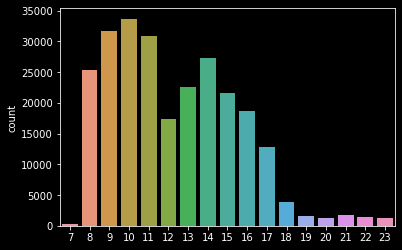

In [28]:
sns.countplot(session_start_hour);

The same separately for Alice and everybody else

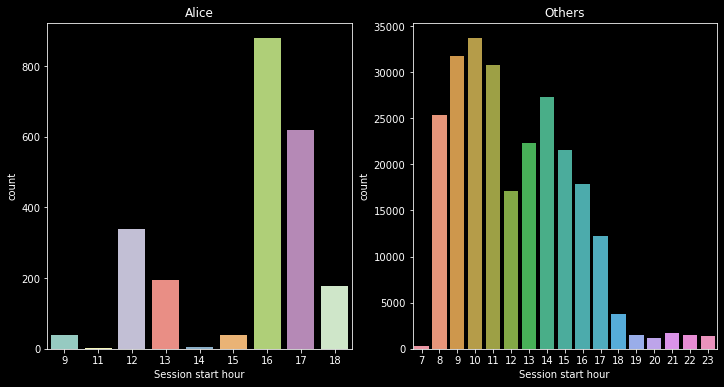

In [31]:
plt.subplots(1, 2, figsize=(12,6))

plt.subplot(1, 2, 1)
sns.countplot(session_start_hour[y_train == 1])
plt.title('Alice')
plt.xlabel('Session start hour')

plt.subplot(1, 2, 2)
sns.countplot(session_start_hour[y_train == 0])
plt.title('Others')
plt.xlabel('Session start hour');


Conclusion: Alice mostly prefers 4-5 pm for browsing. Create features *morning, day, evening, night*. Separators between these times of the day will by almost arbitrary: 0 am, 7am, 12am, 7pm.

In [32]:
morning = ((session_start_hour >= 7) & (session_start_hour <= 11)).astype('int')
day = ((session_start_hour >= 12) & (session_start_hour <= 18)).astype('int')
evening = ((session_start_hour >= 19) & (session_start_hour <= 23)).astype('int')
night = ((session_start_hour >= 0) & (session_start_hour <= 6)).astype('int')

In [33]:
pd.crosstab([morning, day, evening, night], y_train, rownames=['morning', 'day', 'evening', 'night'])

col_0                           0     1
morning day evening night              
0       0   1       0        7251     0
        1   0       0      122129  2256
1       0   0       0      121884    41

Create a separate function to add new features. To demonstrate possible overfitting, keep a flag - whether to add an **hour** feature or not.

In [11]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1,1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1,1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1,1)
    # night is useless feature
    night = ((hour >= 0) & (hour <= 6)).astype('int').values.reshape(-1,1)
    work_hours = ((hour >= 9) & (hour <= 18)).astype('int').values.reshape(-1,1)
    
    objects_to_hstack = [X_sparse
                         , morning
                         , day
                         , evening
#                          , night
#                          , work_hours
                        ]
    feature_names = [
        'morning', 
        'day', 
        'evening', 
#         'night', 
#         'work_hours'
    ]
    
    if add_hour:
        # do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [165]:
hour = train_times_3['time1'].apply(lambda ts: ts.hour)
morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1,1)
day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1,1)
evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1,1)
work_hours = ((hour >= 9) & (hour <= 18)).astype('int').values.reshape(-1,1)

In [166]:
np.unique(work_hours)

array([0, 1])

In [49]:
%%time
X_train_with_times1, new_feature_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

Wall time: 5.68 s


In [38]:
X_train_with_times1.shape, X_test_with_times1.shape

((253561, 50005), (82797, 50005))

Perform time series cross-validation (improvement in ROC AUC

In [39]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train_with_times1, y_train=y_train, 
                              X_test=X_test_with_times1,
                              site_feature_names=vectorizer.get_feature_names(),
                              new_feature_names=new_feature_names, cv=time_split,
                              submission_file_name='subm2.csv')

CV scores [0.81904687 0.78705941 0.94510729 0.96676436 0.88993687 0.96695898
 0.9182761  0.93962258 0.96595914 0.96884529]
CV mean: 0.9167576893172427, CV std: 0.06210632157468878


Weight?,Feature
+7.045,hour
+5.148,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.988,www.express.co.uk
+4.833,youwatch.org
+4.804,www.info-jeunes.net
+4.679,vk.com
+4.567,www.melty.fr
+4.330,fr.glee.wikia.com
+4.100,www.audienceinsights.net
+3.962,www.banque-chalus.fr


New feature names:
   feature      coef
0  morning -2.904869
1      day -0.613760
2  evening -5.069573
3    night  0.000000
4     hour  7.045139


See improvement almost for all folds as compared to the results of previous cross-validation

In [40]:
cv_scores2 > cv_scores1

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### Submission 3: Example of overfitting

New submission improve LB score 0.91807 -> 0.93089. Looks good as compared to sites only. Be a bit wary that feature **hour** gets such a big weight (7.04...). Try the same features, but without **hour**.

In [60]:
%%time
X_train_with_times2, new_feature_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)

X_train_with_times2.shape, X_test_with_times2.shape

Wall time: 1.92 s


((253561, 50004), (82797, 50004))

In [59]:
cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                              X_test=X_test_with_times2,
                              site_feature_names=vectorizer.get_feature_names(),
                              new_feature_names=new_feature_names, cv=time_split,
                              submission_file_name='subm3.csv')

CV scores [0.88170019 0.81426901 0.91861327 0.96171465 0.91532998 0.95227476
 0.9280461  0.94016178 0.94665449 0.95277436]
CV mean: 0.921153858597642, CV std: 0.042064195221825675


Weight?,Feature
+5.218,youwatch.org
+5.093,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.971,www.express.co.uk
+4.914,vk.com
+4.640,fr.glee.wikia.com
+4.542,www.info-jeunes.net
+4.382,www.melty.fr
+4.183,www.audienceinsights.net
+4.104,www.banque-chalus.fr
+3.823,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature names:
   feature      coef
0  morning -3.211819
1      day  0.526636
2  evening -2.721465
3    night  0.000000


Now cross-validation is much more stable. 3rd CV results are better for each and every fold as compared to the first ones. And actually the situation is better than with the **hour** feature for 5 folds out of 10, but in such case prefer a model with less variation of CV results, i.e. the last one.

In [44]:
cv_scores3 > cv_scores1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [45]:
cv_scores3 > cv_scores2

array([ True,  True, False, False,  True, False,  True,  True, False,
       False])

Making a new submission get 0.94535 public LB score instead of 0.93089 when adding the hour feature. The hour feature leads to overfitting and it's better not to add it.

#### Submission 4 and 5: The importance of feature scaling

Add a new feature: session duration. Beware: 1st do it in an incorrect way, then correct.

In [12]:
def add_session_duration(times, X_sparse):    
    # calculate session duration feature
    duration = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[s]').astype(int)
#     duration = ((times.max(axis=1) - times.min(axis=1)) / np.timedelta64(1, 's'))
    session_short = (duration < 2.0).astype('int').values.reshape(-1, 1)
    session_long = (duration >= 2.0).astype('int').values.reshape(-1, 1)
    
    # scale feature
    scaler = StandardScaler()
    duration_scaled = scaler.fit_transform(duration.values.reshape(-1, 1))
    
    features_to_stack = [X_sparse, 
                         duration_scaled,
                         session_short, session_long
                        ]
    features_names = [
        'duration_scaled',
        'session_short', 'session_long'
    ]

    return hstack(features_to_stack), features_names

In [62]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

X_train_with_time_incorrect.shape, X_test_with_time_incorrect.shape

((253561, 50005), (82797, 50005))

In [65]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train, 
                              X_test=X_test_with_time_incorrect,
                              site_feature_names=vectorizer.get_feature_names(),
                              new_feature_names=new_feature_names + ['sess_duration'],
                              cv=time_split, submission_file_name='subm4.csv')

CV scores [0.57324417 0.6057354  0.59064502 0.55137641 0.63484782 0.66004053
 0.74572105 0.67174803 0.61461151 0.61200149]
CV mean: 0.6259971432088414, CV std: 0.05291615658123371


y=1
 
 

top features
 
 
 
 
 
 
 
 Weight ? 
 
 
 Feature 
 
 
 
 
 
 
 
 
 … 1784 more positive … 
 
 
 

 
 
 
 … 48191 more negative … 
 
 
 
 
 
 
 -0.009
 
 
 khms1.google.fr
 
 
 
 
 
 
 -0.009
 
 
 ts2.mm.bing.net
 
 
 
 
 
 
 -0.010
 
 
 s.ytimg.com
 
 
 
 
 
 
 -0.010
 
 
 www.youtube.com
 
 
 
 
 
 
 -0.010
 
 
 mail.google.com
 
 
 
 
 
 
 -0.011
 
 
 clients1.google.com
 
 
 
 
 
 
 -0.012
 
 
 mts1.google.com
 
 
 
 
 
 
 -0.012
 
 
 ajax.googleapis.com
 
 
 
 
 
 
 -0.012
 
 
 twitter.com
 
 
 
 
 
 
 -0.012
 
 
 mts0.google.com
 
 
 
 
 
 
 -0.014
 
 
 accounts.google.com
 
 
 
 
 
 
 -0.015
 
 
 ts1.mm.bing.net
 
 
 
 
 
 
 -0.015
 
 
 connect.facebook.net
 
 
 
 
 
 
 -0.019
 
 
 www.google.fr
 
 
 
 
 
 
 -0.021
 
 
 s-static.ak.facebook.com
 
 
 
 
 
 
 -0.022
 
 
 static.ak.facebook.com
 
 
 
 
 
 
 -0.023
 
 
 www.bing.com
 
 
 
 
 
 
 -0.024
 
 
 apis.google.com
 
 
 
 
 
 
 -0.025
 
 
 www.google.com
 
 
 
 
 
 
 -0.026
 
 
 platform.twitter.com
 
 
 
 
 
 
 -0.038
 
 
 www.facebook.com
 
 
 
 
 
 
 -0.044
 
 
 unknown unknown unknown unknown unknown
 
 
 
 
 
 
 -0.045
 
 
 evening
 
 
 
 
 
 
 -0.054
 
 
 unknown unknown unknown unknown
 
 
 
 
 
 
 -0.065
 
 
 unknown unknown unknown
 
 
 
 
 
 
 -0.075
 
 
 unknown unknown
 
 
 
 
 
 
 -0.084
 
 
 unknown
 
 
 
 
 
 
 -0.603
 
 
 day
 
 
 
 
 
 
 -0.690
 
 
 morning
 
 
 
 
 
 
 -1.337
 
 
 <BIAS>

New feature names:
         feature      coef
0        morning -0.689711
1            day -0.602607
2        evening -0.045053
3          night  0.000000
4  sess_duration -0.000044


Reason of deterioration: The new feature is session duration in milliseconds, it's maximal value is very high. Need to either scale a new feature or measure it in some different units. But feature scaling is more universal technique.

In [109]:
X_test_with_time_incorrect.getcol(-1).data.max()

1800000.0

In [7]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype('int')
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype('int')

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

NameError: name 'train_times' is not defined

In [114]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

X_train_with_time_correct.shape, X_test_with_time_correct.shape

((253561, 50005), (82797, 50005))

In [115]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train,
                              X_test=X_test_with_time_correct,
                              site_feature_names=vectorizer.get_feature_names(),
                              new_feature_names=new_feature_names + ['sess_duration'],
                              cv=time_split, submission_file_name='subm5.csv')

CV scores [0.86809822 0.81821851 0.91950263 0.96171682 0.91593618 0.95368912
 0.93028048 0.94128874 0.94847477 0.95287352]
CV mean: 0.9210078979580925, CV std: 0.042878314417227434


Weight?,Feature
+5.212,youwatch.org
+5.058,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.974,vk.com
+4.969,www.express.co.uk
+4.617,fr.glee.wikia.com
+4.532,www.info-jeunes.net
+4.363,www.melty.fr
+4.148,www.banque-chalus.fr
+4.146,www.audienceinsights.net
+3.792,r4---sn-gxo5uxg-jqbe.googlevideo.com


New feature names:
         feature      coef
0        morning -3.230468
1            day  0.509579
2        evening -2.722820
3          night  0.000000
4  sess_duration -0.241711


New model predicts better on 9 folds out of 10 as compared to the model with sites and time features. Submitting yields 0.94630 Public LB ROC AUC

In [116]:
cv_scores5 > cv_scores3

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

#### Submission 6: Adding more time features

In real competition it's very important to keep track of Public Kernels and borrow some ideas from them. Explore kernel and decide to add features: day of week and month.

In [13]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)    
#     month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
    # linear trend: time in a form YYYYMM, can divide by 1e5 to scale this feature
#     year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1)/1e5
    # feature for holidays (saturday & sunday)
    holiday = times['time1'].apply(lambda t: t.weekday() > 4 ).values.reshape(-1, 1)
    # One Hot Encoding (OHE) weekdays
    monday = times['time1'].apply(lambda t: t.weekday() == 0).astype('int').values.reshape(-1, 1)
    tuesday = times['time1'].apply(lambda t: t.weekday() == 1).astype('int').values.reshape(-1, 1)
    wednesday = times['time1'].apply(lambda t: t.weekday() == 2).astype('int').values.reshape(-1, 1)
    thursday = times['time1'].apply(lambda t: t.weekday() == 3).astype('int').values.reshape(-1, 1)
    friday = times['time1'].apply(lambda t: t.weekday() == 4).astype('int').values.reshape(-1, 1)
    saturday = times['time1'].apply(lambda t: t.weekday() == 5).astype('int').values.reshape(-1, 1)
    sunday = times['time1'].apply(lambda t: t.weekday() == 6).astype('int').values.reshape(-1, 1)
    
    # OHE seasons: winter, spring, summer, autumn
#     winter = times['time1'].apply(lambda t: t.month in [12, 1, 2]).values.reshape(-1, 1)
#     spring = times['time1'].apply(lambda t: t.month in [3, 4, 5]).values.reshape(-1, 1)
#     summer = times['time1'].apply(lambda t: t.month in [6, 7, 8]).values.reshape(-1, 1)
#     autumn = times['time1'].apply(lambda t: t.month in [9, 10, 11]).values.reshape(-1, 1)
    
    # days when Alice is mostly online
#     online_day = times['time1'].apply(lambda t: t.dayofweek in [0,1,3,4]).astype('int').values.reshape(-1, 1)
    # OHE months
#     january = times['time1'].apply(lambda t: t.month == 1).values.reshape(-1, 1)
#     february = times['time1'].apply(lambda t: t.month == 2).values.reshape(-1, 1)
#     march = times['time1'].apply(lambda t: t.month == 3).values.reshape(-1, 1)
#     april = times['time1'].apply(lambda t: t.month == 4).values.reshape(-1, 1)
#     may = times['time1'].apply(lambda t: t.month == 5).values.reshape(-1, 1)
#     june = times['time1'].apply(lambda t: t.month == 6).values.reshape(-1, 1)
    
#     july = times['time1'].apply(lambda t: t.month == 7).values.reshape(-1, 1)
#     august = times['time1'].apply(lambda t: t.month == 8).values.reshape(-1, 1)
#     september = times['time1'].apply(lambda t: t.month == 9).values.reshape(-1, 1)
#     october = times['time1'].apply(lambda t: t.month == 10).values.reshape(-1, 1)
#     november = times['time1'].apply(lambda t: t.month == 11).values.reshape(-1, 1)
#     december = times['time1'].apply(lambda t: t.month == 12).values.reshape(-1, 1)
        
    objects_to_hstack = [X_sparse, 
                         day_of_week, 
#                          month, 
#                          year_month, 
                         holiday, 
                         monday, 
                         tuesday, 
                         wednesday, 
                         thursday, friday, saturday, 
                         sunday
#                          winter, 
#                          spring, 
#                          summer, 
#                          autumn
#                          online_day
#                          january, february, march, april, 
#                          may, 
#                          june, july, august, 
#                          september, october, 
#                          november, december
                        ]
    feature_names = [
        'day_of_week', 
#         'month', 
#         'year_month', 
        'holiday', 
        'monday', 
        'tuesday', 
        'wednesday', 
        'thursday', 'friday', 'saturday', 
        'sunday'
#         'winter', 
#         'spring', 
#         'summer', # useless feature
#         'autumn'
#         'online_day'
#         'january', 'february', 'march', 'april', 
#         'may', 
#         'june', 'july', 'august', 
#         'september', 'october', 
#         'november', 'december'
    ]
    
    X = hstack(objects_to_hstack)
    return X, feature_names

In [ ]:
day_of_week = train_times_3['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
month = train_times_3['time1'].apply(lambda t: t.month).values.reshape(-1, 1)
# linear trend: time in a form YYYYMM, can divide by 1e5 to scale this feature
year_month = train_times_3['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1)/1e5
# feature for holidays (saturday & sunday)
holiday = train_times_3['time1'].apply(lambda t: t.weekday() > 4 ).values.reshape(-1, 1)

In [172]:
np.unique(holiday)

array([False,  True])

In [120]:
X_train_final, more_feature_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

X_train_final.shape, X_test_final.shape

NameError: name 'X_train_with_time_correct' is not defined

In [121]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train,
                              X_test=X_test_final,
                              site_feature_names=vectorizer.get_feature_names(),
                              new_feature_names=new_feature_names + ['sess_duration'] + more_feature_names,
                              cv=time_split, submission_file_name='subm6.csv')

CV scores [0.76714843 0.81597222 0.90541645 0.96307368 0.91625327 0.95853311
 0.9272257  0.95188228 0.95890638 0.96919612]
CV mean: 0.9133607642983579, CV std: 0.06504929264184725


Weight?,Feature
+5.163,youwatch.org
+5.039,vk.com
+5.011,www.express.co.uk
+4.986,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.690,www.info-jeunes.net
+4.441,www.melty.fr
+4.387,fr.glee.wikia.com
+4.335,www.audienceinsights.net
+4.021,www.banque-chalus.fr
+3.963,api.bing.com


New feature names:
         feature      coef
0        morning -1.660459
1            day  2.059668
2        evening -1.737735
3          night  0.000000
4  sess_duration -0.262817
5    day_of_week -0.367637
6          month  0.108568
7     year_month -2.754080


#### Submission 7: Tuning params

When feature engineering is done (no more ideas) can tune hyperparameters in model. Here used several params - ngram_range, max_features. Choosing between CountVectorizer and TfIdfVectorizer might also be treated as a hyperparameter. Now tune only regularization strength C.

In [30]:
c_values = np.logspace(-1, 2, 20)
logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values}, scoring='roc_auc', 
                                   n_jobs=-1, cv=time_split, verbose=1)

In [123]:
%%time
logit_grid_searcher.fit(X_train_final, y_train);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.9min finished


Wall time: 4min 56s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, random_state=17,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=1)

In [124]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9164523001839875, {'C': 5.455594781168514})

In [125]:
final_model = logit_grid_searcher.best_estimator_

In [126]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train,
                              X_test=X_test_final,
                              site_feature_names=vectorizer.get_feature_names(),
                              new_feature_names=new_feature_names + ['sess_duration'] + more_feature_names, 
                              cv=time_split, submission_file_name='subm7.csv')

CV scores [0.78840326 0.79493407 0.91689254 0.97284747 0.91797801 0.95464224
 0.9472145  0.9447872  0.96216418 0.96465954]
CV mean: 0.9164523001839875, CV std: 0.06478220297038217


Weight?,Feature
+12.816,www.express.co.uk
+11.956,cid-ed6c3e6a5c6608a4.users.storage.live.com
+8.494,tru.am
+7.389,browser-update.org
+6.709,fr.glee.wikia.com
+6.535,www.banque-chalus.fr
+6.490,api.bing.com
+6.289,glee.hypnoweb.net
+6.177,mcetv.fr
+6.161,www.springboardplatform.com


New feature names:
         feature      coef
0        morning -1.426427
1            day  2.475479
2        evening -2.575346
3          night  0.000000
4  sess_duration -0.195874
5    day_of_week -0.379926
6          month  0.132165
7     year_month -3.376453


Tuning params helps only for 6 folds out of 10. Typically in such situation can make one more submission to compare LB scores as well. 0.94961 - it's less than without hyperparameter tuning.
**Bad news in the end**: our CV scheme not perfect. Need to improve it. *Hint*: is all training set needed for a good prediction?

In [127]:
cv_scores7 > cv_scores6

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False])

#### Analyzing submission history

Summarize CV results and LB scores for all 7 submissions:

In [130]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, 
                                                             cv_scores4, cv_scores5, cv_scores6, cv_scores7]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3, 
                                                             cv_scores4, cv_scores5, cv_scores6, cv_scores7]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95062, 0.94961]
subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_stds': cv_stds, 'LB': public_lb_scores},
                     index=range(1, len(cv_means) + 1))
subm_df

,CV_mean,CV_stds,LB
1,0.86253,0.07456,0.91807
2,0.91676,0.06211,0.93135
3,0.92115,0.04206,0.94526
4,0.62600,0.05292,0.67016
5,0.92101,0.04288,0.94620
6,0.91336,0.06505,0.95062
7,0.91645,0.06478,0.94961


The correlation between CV mean and LB exists, but it's not perfect. So which submission to choose in the end? A popular method is to treat mean CV and LB results with weights, proportional to train and test sizes. However, considering time, trust public LB score more and set it's weight to 0.6 (no theory here, only practical experience). Also, as seen, standard deviation of CV results is also important, so experiment here.

In [131]:
subm_df['cv_lb_weighted'] = 0.6 * subm_df['LB'] + (1 - 0.6) * subm_df['CV_mean']
subm_df
# Submission 7 is the best one

,CV_mean,CV_stds,LB,cv_lb_weighted
1,0.86253,0.07456,0.91807,0.895854
2,0.91676,0.06211,0.93135,0.925514
3,0.92115,0.04206,0.94526,0.935616
4,0.62600,0.05292,0.67016,0.652496
5,0.92101,0.04288,0.94620,0.936124
6,0.91336,0.06505,0.95062,0.935716
7,0.91645,0.06478,0.94961,0.936346


#### Conclusions:

- keep track of CV improvements for *each* fold (or at least as many folds as possible)
- take a look at CV std, not only mean
- try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important)
- exploring feature importance might help, sometimes even in detecting overfitting
- spend most of the competition time exploring data and building features

#### Submission 8: Try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important). Is all training set needed for a good prediction?

Analyze Alice min start date, max finish date (min start time, max start time get from early analysis) and create new dataframe without this records to get more precision time series cross validation.

In [268]:
train_times_3.shape, y_train_3.shape

((237371, 10), (237371,))

In [279]:
#min, max date in all data and Alice start date
train_times_3[y_train_3 == 1]['time1'].astype(dtype='datetime64[D]').max()
# not alice min date Timestamp('2013-01-12 00:00:00')
# not alice max date Timestamp('2014-04-30 00:00:00')
# alice min date Timestamp('2013-02-12 00:00:00')
# alice max date Timestamp('2014-04-15 00:00:00')

# After date fixing
# not alice min date Timestamp('2013-11-15 00:00:00')
# not alice max date Timestamp('2014-04-30 00:00:00')
# alice min date Timestamp('2013-11-15 00:00:00')
# alice max date Timestamp('2014-04-15 00:00:00')

Timestamp('2014-04-15 00:00:00')

In [280]:
session_alice_date = \
(train_times[(y_train == 1) &\
             (train_times['time1'].astype(dtype='datetime64[D]') > '2013-11-14 00:00:00') & \
             (train_times['time1'].astype(dtype='datetime64[D]') < '2014-04-16 00:00:00')])\
['time1'].astype(dtype='datetime64[D]')

session_other_date = \
(train_times[(y_train == 0) &\
             (train_times['time1'].astype(dtype='datetime64[D]') > '2013-11-14 00:00:00') & \
             (train_times['time1'].astype(dtype='datetime64[D]') < '2014-04-16 00:00:00')])\
['time1'].astype(dtype='datetime64[D]')

session_all_date = \
(train_times[(train_times['time1'].astype(dtype='datetime64[D]') > '2013-11-14 00:00:00') & \
             (train_times['time1'].astype(dtype='datetime64[D]') < '2014-04-16 00:00:00')])\
['time1'].astype(dtype='datetime64[D]')

session_alice_date.shape, session_other_date.shape, session_all_date.shape
# Alice 2297
# Other 235074

((1821,), (208908,), (210729,))

In [285]:
session_alice_date.min(), session_alice_date.max()

(Timestamp('2013-11-15 00:00:00'), Timestamp('2014-04-15 00:00:00'))

Plot the start session date separately for Alice and other

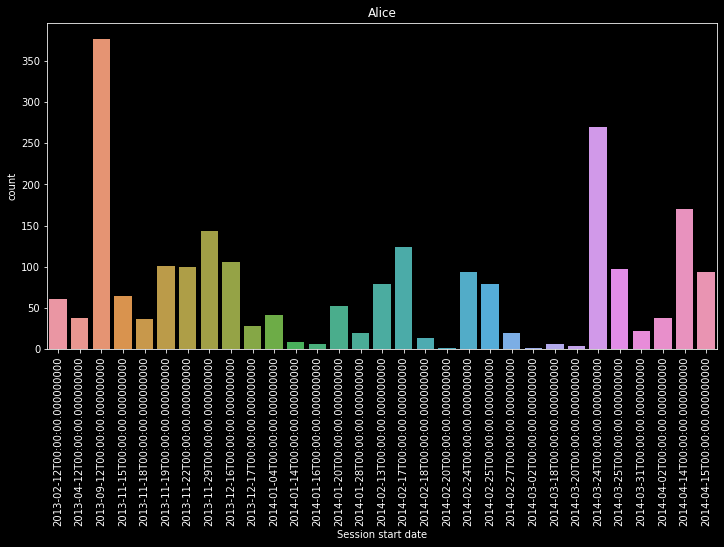

In [283]:
plt.subplots(1, 1, figsize=(12,6))

plt.subplot(1, 1, 1)
sns.countplot(session_alice_date)
plt.title('Alice')
plt.xlabel('Session start date')
plt.xticks(rotation=90);

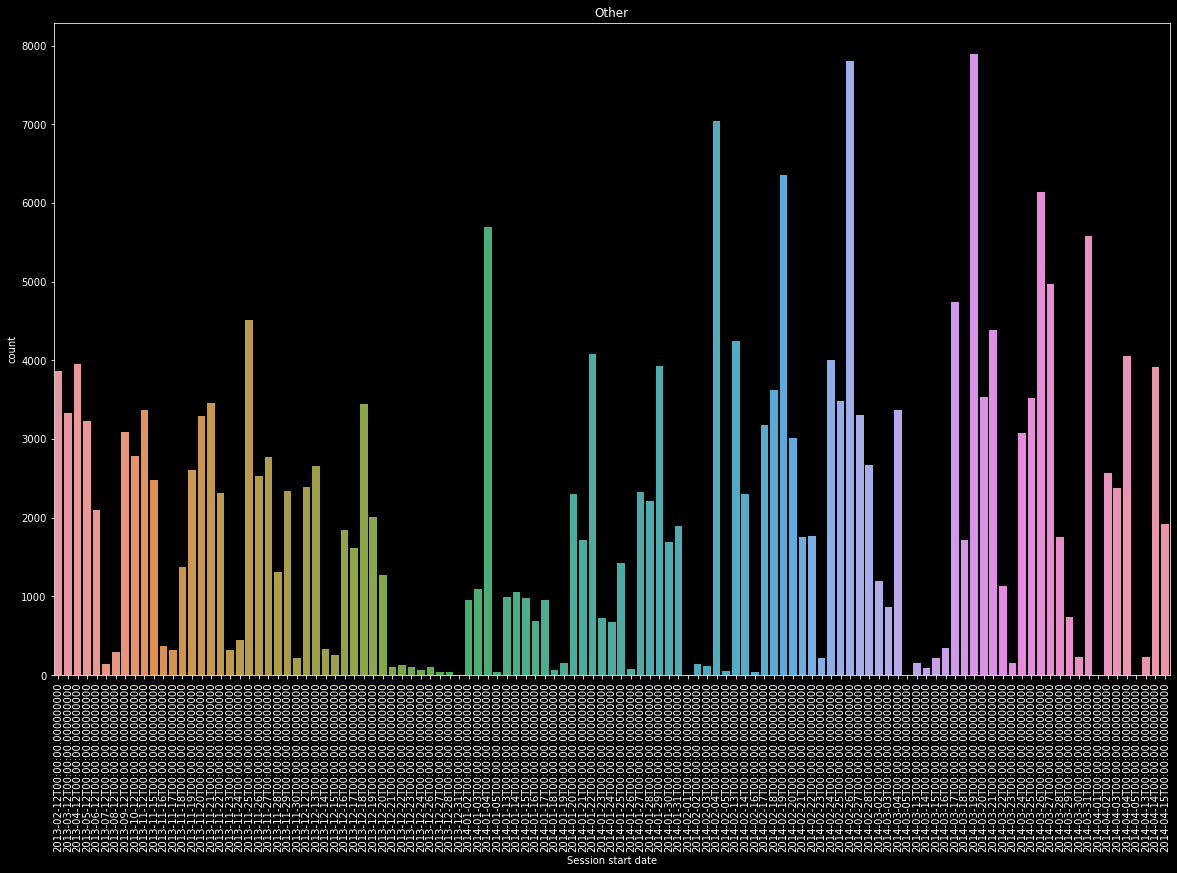

In [201]:
plt.subplots(1, 1, figsize=(20,12))

plt.subplot(1, 1, 1)
sns.countplot(session_other_date)
plt.title('Other')
plt.xlabel('Session start date')
plt.xticks(rotation=90);

In [234]:
np.unique(train_times_3['time1'].astype(dtype='datetime64[D]'))

array(['2013-02-12T00:00:00.000000000', '2013-03-12T00:00:00.000000000',
       '2013-04-12T00:00:00.000000000', '2013-05-12T00:00:00.000000000',
       '2013-06-12T00:00:00.000000000', '2013-07-12T00:00:00.000000000',
       '2013-08-12T00:00:00.000000000', '2013-09-12T00:00:00.000000000',
       '2013-10-12T00:00:00.000000000', '2013-11-12T00:00:00.000000000',
       '2013-11-15T00:00:00.000000000', '2013-11-16T00:00:00.000000000',
       '2013-11-17T00:00:00.000000000', '2013-11-18T00:00:00.000000000',
       '2013-11-19T00:00:00.000000000', '2013-11-20T00:00:00.000000000',
       '2013-11-21T00:00:00.000000000', '2013-11-22T00:00:00.000000000',
       '2013-11-23T00:00:00.000000000', '2013-11-24T00:00:00.000000000',
       '2013-11-25T00:00:00.000000000', '2013-11-26T00:00:00.000000000',
       '2013-11-27T00:00:00.000000000', '2013-11-28T00:00:00.000000000',
       '2013-11-29T00:00:00.000000000', '2013-11-30T00:00:00.000000000',
       '2013-12-12T00:00:00.000000000', '2013-12-13

In [208]:
np.unique(test_times_3['time1'].astype(dtype='datetime64[D]'))

array(['2014-05-01T00:00:00.000000000', '2014-05-02T00:00:00.000000000',
       '2014-05-03T00:00:00.000000000', '2014-05-04T00:00:00.000000000',
       '2014-05-05T00:00:00.000000000', '2014-05-13T00:00:00.000000000',
       '2014-05-14T00:00:00.000000000', '2014-05-15T00:00:00.000000000',
       '2014-05-16T00:00:00.000000000', '2014-05-17T00:00:00.000000000',
       '2014-05-18T00:00:00.000000000', '2014-05-19T00:00:00.000000000',
       '2014-05-20T00:00:00.000000000', '2014-05-21T00:00:00.000000000',
       '2014-05-22T00:00:00.000000000', '2014-05-23T00:00:00.000000000',
       '2014-05-24T00:00:00.000000000', '2014-05-25T00:00:00.000000000',
       '2014-05-26T00:00:00.000000000', '2014-05-27T00:00:00.000000000',
       '2014-05-28T00:00:00.000000000', '2014-06-01T00:00:00.000000000',
       '2014-06-02T00:00:00.000000000', '2014-06-04T00:00:00.000000000',
       '2014-06-05T00:00:00.000000000', '2014-07-01T00:00:00.000000000',
       '2014-07-02T00:00:00.000000000', '2014-07-03

Based on https://www.kaggle.com/sgdread/model-validation-in-a-competition-fixing-cv

Conclusion: Train data contain strange dates from 2013-02-12 to 2013-11-12.
It looks like the dataset has parsing error: we have dates in two formats: YYYY-MM-DD and YYYY-DD-MM. Need to fix it.

In [239]:
times = ['time%s' % i for i in range(1, 11)]

In [15]:
def fix_incorrect_date_formats(df, columns_to_fix):
    for time in columns_to_fix:
        d = df[time]
        d_fix = d[d.astype(dtype='datetime64[D]') <= '2013-11-12 00:00:00']
#         d_fix = d[d.dt.day <= 12]
        d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
        df.loc[d_fix.index.values, time] = d_fix
    return df

In [266]:
d = train_times_3['time1']
d_fix = d[d.astype(dtype='datetime64[D]') <= '2013-11-12 00:00:00']
d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
#df.loc[d_fix.index.values, time] = d_fix
d_fix

session_id
127108   2013-12-02 07:48:43
64683    2013-12-02 07:53:05
42711    2013-12-02 07:56:32
26344    2013-12-02 08:00:51
42568    2013-12-02 08:02:51
                 ...        
191328   2013-12-11 23:37:49
78153    2013-12-11 23:37:54
243527   2013-12-11 23:39:10
44020    2013-12-11 23:42:11
160739   2013-12-11 23:52:36
Name: time1, Length: 26642, dtype: datetime64[ns]

In [285]:
#alice_time = 
((train_times['time1'].apply(lambda ts: ts.hour).values > 8) & 
           (train_times['time1'].apply(lambda ts: ts.hour).values < 19))

array([False, False, False, ..., False, False, False])

In [174]:
train_times[(y_train == 1) & alice_time]['time1'].count()
# alice time not alice 218303
# alice time alice 2297
# alice time all 220600

2297

#### Submission 8.1: Change DataFrame with Alice session times (from min to max). Add features and train logit.

In [408]:
def prepare_sparse_features_with_alice_time(path_to_train, path_to_test, path_to_site_dict, \
                                            vectorizer_params, after_load_fn=None):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    # sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    if after_load_fn is not None:
        train_df = after_load_fn(train_df)
        test_df = after_load_fn(test_df)
    
    # filter data in accordance with start session time of Alice
    train_df = train_df[((train_df['time1'].apply(lambda ts: ts.hour).values > 8) & 
                         (train_df['time1'].apply(lambda ts: ts.hour).values < 19))]
    
    # read site -> id mapping
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create inverse dict id -> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # transform data for fed into TfidfVEctorizer
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times


In [409]:
%%time
X_train_sites_2, X_test_sites_2, y_train_2, vectorizer_2, train_times_2, test_times_2 = \
prepare_sparse_features_with_alice_time(
    after_load_fn=(lambda df: fix_incorrect_date_formats(df, times)),
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={
        'ngram_range': (1, 5),
        'max_features': 100000,
        'tokenizer': lambda s: s.split()
    }
)

Wall time: 48 s


In [26]:
train_times_2['time1'].min(), train_times_2['time1'].max()

(Timestamp('2013-01-12 09:10:04'),
 Timestamp('2014-04-30 18:24:35'),
 Timestamp('2014-04-30 23:39:53'))

In [412]:
X_train_sites_2.shape, X_test_sites_2.shape

((220600, 100000), (82797, 100000))

In [489]:
vectorizer_2.get_feature_names()[10010:10030]

['armmf.adobe.com armmf.adobe.com www.oracle.com',
 'armmf.adobe.com armmf.adobe.com www.oracle.com apex.oracle.com',
 'armmf.adobe.com armmf.adobe.com www.oracle.com apex.oracle.com www.oracle.com',
 'armmf.adobe.com clients1.google.com',
 'armmf.adobe.com dl.javafx.com',
 'armmf.adobe.com fpdownload2.macromedia.com',
 'armmf.adobe.com fpdownload2.macromedia.com www.google.fr',
 'armmf.adobe.com go.microsoft.com',
 'armmf.adobe.com go.microsoft.com windows.microsoft.com',
 'armmf.adobe.com go.microsoft.com www.iegallery.com',
 'armmf.adobe.com go.microsoft.com www.iegallery.com www.iegallery.com',
 'armmf.adobe.com google.fr',
 'armmf.adobe.com google.fr www.google.fr',
 'armmf.adobe.com gtssl-ocsp.geotrust.com',
 'armmf.adobe.com gtssl-ocsp.geotrust.com armmf.adobe.com',
 'armmf.adobe.com ieonline.microsoft.com',
 'armmf.adobe.com javadl-esd-secure.oracle.com',
 'armmf.adobe.com javadl-esd-secure.oracle.com javadl-esd-secure.oracle.com',
 'armmf.adobe.com javadl-esd-secure.oracle.com

In [410]:
%%time
# add time features ['morning', 'day', 'evening', 'night']
X_train_with_times_2, new_feature_names_2 = add_time_features(train_times_2, X_train_sites_2, 
                                                              add_hour=False)
X_test_with_times_2, _ = add_time_features(test_times_2, X_test_sites_2, add_hour=False)

Wall time: 3.14 s


In [411]:
X_train_with_times_2.shape, X_test_with_times_2.shape

((220600, 100004), (82797, 100004))

In [413]:
# add scaled session duration feature
train_durations_2 = (train_times_2.max(axis=1) - train_times_2.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations_2 = (test_times_2.max(axis=1) - test_times_2.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled_2 = scaler.fit_transform(train_durations_2.values.reshape(-1, 1))
test_dur_scaled_2 = scaler.transform(test_durations_2.values.reshape(-1, 1))

X_train_with_times_2 = hstack([X_train_with_times_2, train_dur_scaled_2])
X_test_with_times_2 = hstack([X_test_with_times_2, test_dur_scaled_2])

In [414]:
X_train_with_times_2.shape, X_test_with_times_2.shape

((220600, 100005), (82797, 100005))

In [415]:
# add more features: day_of_week, month, year_month
X_train_with_times_2, more_feature_names = add_day_month(train_times_2, X_train_with_times_2)
X_test_with_times_2, _ = add_day_month(test_times_2, X_test_with_times_2)

In [416]:
X_train_with_times_2.shape, X_test_with_times_2.shape

((220600, 100009), (82797, 100009))

In [417]:
cv_scores8_1 = train_and_predict(model=logit, X_train=X_train_with_times_2, y_train=y_train_2, 
                               X_test=X_test_with_times_2, 
                               site_feature_names=vectorizer_2.get_feature_names(),
                               new_feature_names=new_feature_names_2 + ['sess_duration'] + more_feature_names,
                               cv=time_split, submission_file_name='subm8_1_3.csv')

CV scores [0.62334213 0.74441311 0.92847579 0.96253369 0.89393182 0.96670743
 0.92719088 0.96292065 0.95830416 0.97284786]
CV mean: 0.8940667514543665, CV std: 0.11090870017939243


Weight?,Feature
+5.537,youwatch.org
+5.438,vk.com
+4.947,www.melty.fr
+4.710,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.563,www.info-jeunes.net
+4.527,www.audienceinsights.net
+4.335,www.express.co.uk
+4.275,fr.glee.wikia.com
+4.170,i1.ytimg.com
+3.800,www.banque-chalus.fr


New feature names:
         feature      coef
0        morning -1.762164
1            day  1.758964
2        evening  0.000000
3     work_hours -0.003201
4  sess_duration -0.278548
5    day_of_week -0.634007
6          month  0.097204
7     year_month  0.003971
8        holiday -1.158039


In [419]:
cv_scores8_1 > cv_scores8_2

array([False,  True,  True, False, False,  True, False,  True, False,
        True])

In [70]:
%%time
# Tuning param C
logit_grid_searcher.fit(X_train_with_times_2, y_train_2);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.7min finished


Wall time: 4min 44s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, random_state=17,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=1)

In [71]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9072692494843333, {'C': 3.359818286283781})

In [72]:
model_8_1 = logit_grid_searcher.best_estimator_

In [73]:
cv_scores8_1_2 = train_and_predict(model=model_8_1, X_train=X_train_with_times_2, y_train=y_train_2, 
                               X_test=X_test_with_times_2, 
                               site_feature_names=vectorizer_2.get_feature_names(),
                               new_feature_names=new_feature_names_2 + ['sess_duration'] + more_feature_names,
                               cv=time_split, submission_file_name='subm8_1_2.csv')

CV scores [0.7884522  0.76993103 0.8979892  0.96281322 0.91023377 0.94494554
 0.93875213 0.93448422 0.96224284 0.96284835]
CV mean: 0.9072692494843333, CV std: 0.06739568097486014


Weight?,Feature
+10.928,www.express.co.uk
+9.779,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.046,tru.am
+6.354,browser-update.org
+6.119,fr.glee.wikia.com
+5.836,api.bing.com
+5.742,www.banque-chalus.fr
+5.621,youwatch.org
+5.588,vk.com
+5.552,cid-4390f92c7906cc9c.users.storage.live.com


New feature names:
         feature      coef
0        morning -2.425201
1            day  1.178954
2        evening  0.000000
3          night  0.000000
4  sess_duration -0.205221
5    day_of_week -0.371913
6          month  0.125111
7     year_month -2.703613


In [74]:
cv_scores8_1_2 > cv_scores8_1

array([ True, False,  True,  True,  True, False,  True, False,  True,
       False])

#### Submission 8.2: Change DataFrame with Alice start session date (from min to max). Add features and train logit.


In [31]:
def prepare_sparse_features_with_alice_date(path_to_train, path_to_test, path_to_site_dict, \
                                            vectorizer_params, after_load_fn=None):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    # sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # fix incorrect date formats
#     train_df = fix_incorrect_date_formats(train_df, times)
    if after_load_fn is not None:
        train_df = after_load_fn(train_df)
        test_df = after_load_fn(test_df)
    
    # filter data in accordance with start session date of Alice
    train_df = train_df[((train_df['time1'].astype(dtype='datetime64[D]') > 
#                           '2013-02-11 00:00:00')
                         '2013-11-14 00:00:00') 
                         & (train_df['time1'].astype(dtype='datetime64[D]') < '2014-04-16 00:00:00'))]
    
    # read site -> id mapping
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create inverse dict id -> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # transform data for fed into TfidfVEctorizer
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [32]:
%%time
X_train_sites_3, X_test_sites_3, y_train_3, vectorizer_3, train_times_3, test_times_3 =\
prepare_sparse_features_with_alice_date(
#     after_load_fn=(lambda df: fix_incorrect_date_formats(df, times)),
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={
        'ngram_range': (1, 5),
        'max_features': 100000,
        'tokenizer': lambda s: s.split()
    }
)

Wall time: 25 s


In [33]:
train_times_3['time1'].min(), train_times_3['time1'].max()

(Timestamp('2013-11-15 07:39:35'), Timestamp('2014-04-15 23:57:24'))

In [34]:
X_train_sites_3.shape, X_test_sites_3.shape, y_train_3.shape, train_times_3.shape

((210729, 100000), (82797, 100000), (210729,), (210729, 10))

In [35]:
%%time
# add time features ['morning', 'day', 'evening', 'work_hours']
X_train_with_times_3, new_feature_names_3 = add_time_features(train_times_3, X_train_sites_3, 
                                                              add_hour=False)
X_test_with_times_3, _ = add_time_features(test_times_3, X_test_sites_3, add_hour=False)

X_train_with_times_3.shape, X_test_with_times_3.shape, y_train_3.shape

Wall time: 2.34 s


((210729, 100003), (82797, 100003), (210729,))

In [36]:
# calculate session duration feature
# duration = (train_times_3.max(axis=1) - train_times_3.min(axis=1)).astype('timedelta64[s]').astype(int)
# duration=((train_times_3.max(axis=1) - train_times_3.min(axis=1))/np.timedelta64(1, 's'))
# session_short = (duration < 0.8 ).astype('int').values.reshape(-1, 1)
# session_long = (duration >= 0.8).astype('int').values.reshape(-1, 1)
# print(session_short.shape, session_long.shape)

# print(duration[y_train_3==0].describe(), duration[y_train_3==1].describe())
# p = np.linspace(0, 100, 21)
# print(f'More percentiles for duration session of Alice:\n\
# {np.vstack([p, np.percentile(duration[y_train_3==1], p)]).T}')
# plt.ylim(-30, 200)
# sns.boxplot(x=y_train_3, y=duration, data=duration);
# Alice 1821
# Other 208908

In [37]:
# add scaled session duration feature
X_train_with_times_3, session_features = add_session_duration(train_times_3, X_train_with_times_3)
X_test_with_times_3, _ = add_session_duration(test_times_3, X_test_with_times_3)

X_train_with_times_3.shape, X_test_with_times_3.shape

((210729, 100006), (82797, 100006))

In [38]:
# add more features: day_of_week, month, year_month, holiday, etc.
X_train_with_times_3, more_feature_names = add_day_month(train_times_3, X_train_with_times_3)
X_test_with_times_3, _ = add_day_month(test_times_3, X_test_with_times_3)

X_train_with_times_3.shape, X_test_with_times_3.shape

((210729, 100015), (82797, 100015))

In [39]:
new_feature_names_3 + session_features + more_feature_names

['morning',
 'day',
 'evening',
 'duration_scaled',
 'session_short',
 'session_long',
 'day_of_week',
 'holiday',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday']

In [40]:
# %%time
cv_scores8_2 = train_and_predict(model=logit, X_train=X_train_with_times_3, y_train=y_train_3, 
                               X_test=X_test_with_times_3, 
                               site_feature_names=vectorizer_3.get_feature_names(),
                               new_feature_names=new_feature_names_3 + session_features 
                                 + more_feature_names,
                               cv=time_split, submission_file_name='subm8_2_39.csv')
# CV mean: 0.915476629124487,  CV std: 0.05681517926492692|0.95541 
# CV mean: 0.9156042433833402, CV std: 0.05689473009092138|0.95543<--best result


CV scores [0.86622719 0.88481092 0.92661638 0.78395819 0.94767666 0.97486231
 0.90200771 0.96542771 0.9808797  0.92357567]
CV mean: 0.9156042433833402, CV std: 0.05689473009092138
New feature names:
            feature      coef
0           morning -2.341168
1               day  3.307806
2           evening -0.960455
3   duration_scaled -0.296507
4     session_short -0.231037
5      session_long  0.237220
6       day_of_week -0.385843
7           holiday  0.099583
8            monday  0.649368
9           tuesday  0.365159
10        wednesday -1.983353
11         thursday -0.291559
12           friday  1.166985
13         saturday  1.175056
14           sunday -1.075473


In [25]:
cv_scores8_2 > cv_scores8_1, cv_scores8_2 > cv_scores8_4

NameError: name 'cv_scores8_1' is not defined

In [41]:
%%time
# Tuning param C
logit_grid_searcher.fit(X_train_with_times_3, y_train_3);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 26.7min finished


Wall time: 27min 15s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, max_iter=10000, n_jobs=11,
                                          random_state=17),
             n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])},
             scoring='roc_auc', verbose=1)

In [42]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9223619735578492, {'C': 16.23776739188721})

In [43]:
model_8_2 = logit_grid_searcher.best_estimator_

In [44]:
cv_scores8_2_tuned = train_and_predict(model=model_8_2, X_train=X_train_with_times_3, y_train=y_train_3, 
                               X_test=X_test_with_times_3, 
                               site_feature_names=vectorizer_3.get_feature_names(),
                               new_feature_names=new_feature_names_3 + session_features 
                                 + more_feature_names,
                               cv=time_split, submission_file_name='subm8_2_40.csv')

CV scores [0.85529984 0.8883126  0.94260604 0.81267508 0.9497299  0.97461903
 0.92464037 0.96473733 0.98088294 0.93011659]
CV mean: 0.9223619735578492, CV std: 0.05182974905926543
New feature names:
            feature      coef
0           morning -2.258926
1               day  4.135908
2           evening -1.951909
3   duration_scaled -0.159087
4     session_short -0.352830
5      session_long  0.277904
6       day_of_week -0.475597
7           holiday  0.134402
8            monday  0.726159
9           tuesday  0.418507
10        wednesday -2.521511
11         thursday -0.197738
12           friday  1.365255
13         saturday  1.525299
14           sunday -1.390897


In [45]:
cv_scores8_2_tuned > cv_scores8_2

array([False,  True,  True,  True,  True, False,  True, False,  True,
        True])

#### Submission 8.3: Change DataFrame with Alice start session date and time (from min to max). Add all features and train logit.

In [98]:
def prepare_sparse_features_with_alice_date_time(path_to_train, path_to_test, path_to_site_dict, vectorizer_params):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    # sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    # filter data in accordance with start session date (from min to max) of Alice
    train_df = train_df[((train_df['time1'].astype(dtype='datetime64[D]') > '2013-02-11 00:00:00') & 
                         (train_df['time1'].astype(dtype='datetime64[D]') < '2014-04-16 00:00:00'))]
    
    # filter data in accordance with start session time of Alice
    train_df = train_df[((train_df['time1'].apply(lambda ts: ts.hour).values > 8) & 
                         (train_df['time1'].apply(lambda ts: ts.hour).values < 19))]
    
    
    # read site -> id mapping
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create inverse dict id -> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # transform data for fed into TfidfVEctorizer
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [153]:
%%time
X_train_sites_4, X_test_sites_4, y_train_4, vectorizer_4, train_times_4, test_times_4 = prepare_sparse_features_with_alice_date_time(
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={
        'ngram_range': (1, 4),
        'max_features': 100000,
        'tokenizer': lambda s: s.split()
    }
)

Wall time: 23 s


In [154]:
train_times_4['time1'].min(), train_times_4['time1'].max()

(Timestamp('2013-02-12 09:00:37'), Timestamp('2014-04-15 18:45:31'))

In [155]:
X_train_sites_4.shape, X_test_sites_4.shape

((206660, 100000), (82797, 100000))

In [156]:
%%time
# add time features ['morning', 'day', 'evening', 'night']
X_train_with_times_4, new_feature_names = add_time_features(train_times_4, X_train_sites_4, 
                                                              add_hour=False)
X_test_with_times_4, _ = add_time_features(test_times_4, X_test_sites_4, add_hour=False)

Wall time: 2.13 s


In [157]:
X_train_with_times_4.shape, X_test_with_times_4.shape

((206660, 100004), (82797, 100004))

In [158]:
# add scaled session duration feature
train_durations = (train_times_4.max(axis=1) - train_times_4.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times_4.max(axis=1) - test_times_4.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

X_train_with_times_4 = hstack([X_train_with_times_4, train_dur_scaled])
X_test_with_times_4 = hstack([X_test_with_times_4, test_dur_scaled])

In [159]:
X_train_with_times_4.shape, X_test_with_times_4.shape

((206660, 100005), (82797, 100005))

In [160]:
# add more features: day_of_week, month, year_month
X_train_with_times_4, more_feature_names = add_day_month(train_times_4, X_train_with_times_4)
X_test_with_times_4, _ = add_day_month(test_times_4, X_test_with_times_4)

In [161]:
X_train_with_times_4.shape, X_test_with_times_4.shape

((206660, 100008), (82797, 100008))

In [163]:
cv_scores8_3 = train_and_predict(model=logit, X_train=X_train_with_times_4, y_train=y_train_4, 
                               X_test=X_test_with_times_4, 
                               site_feature_names=vectorizer_4.get_feature_names(),
                               new_feature_names=new_feature_names + ['sess_duration'] + more_feature_names,
                               cv=time_split, submission_file_name='subm8_3_6.csv')

CV scores [0.76816414 0.71292401 0.81283894 0.9325558  0.90814731 0.95386267
 0.94051377 0.88847526 0.95829317 0.96128961]
CV mean: 0.8837064693859842, CV std: 0.08383109355897175


Weight?,Feature
+5.517,youwatch.org
+5.428,vk.com
+4.788,www.audienceinsights.net
+4.660,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.655,www.info-jeunes.net
+4.644,www.melty.fr
+4.373,fr.glee.wikia.com
+4.267,www.express.co.uk
+4.255,i1.ytimg.com
+3.861,www.banque-chalus.fr


New feature names:
         feature      coef
0        morning -2.324450
1            day  1.192729
2        evening  0.000000
3          night  0.000000
4  sess_duration -0.248578
5    day_of_week -0.342975
6          month  0.097918
7     year_month -2.311570


In [142]:
cv_scores8_3 > cv_scores8_2_2

array([False, False, False, False, False,  True, False, False, False,
       False])

#### Submission 8.4: Change DataFrame with Alice start session date only (31 unique days). Add all features and train logit.

In [511]:
# check Alice start session dates on DF from submission 8.2 (best result in public LB)
alice_dates =\
train_times_3[(y_train_3 == 1)]['time1'].astype(dtype='datetime64[D]').unique()
alice_dates.shape

(31,)

In [510]:
train_times_3[train_times_3['time1'].astype(dtype='datetime64[D]').isin(alice_dates)]

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
127108,2013-12-02 07:48:43,2013-12-02 07:48:43,2013-12-02 07:48:44,2013-12-02 07:48:44,2013-12-02 07:48:45,2013-12-02 07:49:27,2013-12-02 07:49:28,2013-12-02 07:49:31,2013-12-02 07:49:31,2013-12-02 07:49:32
64683,2013-12-02 07:53:05,2013-12-02 07:53:05,2013-12-02 07:53:05,2013-12-02 07:53:06,2013-12-02 07:53:07,2013-12-02 07:53:38,2013-12-02 07:53:38,2013-12-02 07:53:39,2013-12-02 07:53:39,2013-12-02 07:53:40
42711,2013-12-02 07:56:32,2013-12-02 07:56:32,2013-12-02 07:56:32,2013-12-02 08:00:37,2013-12-02 08:00:37,2013-12-02 08:00:37,2013-12-02 08:00:38,2013-12-02 08:00:38,2013-12-02 08:00:38,2013-12-02 08:00:51
26344,2013-12-02 08:00:51,2013-12-02 08:00:51,2013-12-02 08:00:52,2013-12-02 08:00:52,2013-12-02 08:00:52,2013-12-02 08:01:50,2013-12-02 08:01:50,2013-12-02 08:01:50,2013-12-02 08:02:51,2013-12-02 08:02:51
42568,2013-12-02 08:02:51,2013-12-02 08:02:52,2013-12-02 08:02:53,2013-12-02 08:17:24,2013-12-02 08:17:24,2013-12-02 08:17:24,2013-12-02 08:17:25,2013-12-02 08:17:25,2013-12-02 08:20:13,2013-12-02 08:20:13
...,...,...,...,...,...,...,...,...,...,...
54668,2014-04-15 23:55:04,2014-04-15 23:55:14,2014-04-15 23:55:18,2014-04-15 23:55:30,2014-04-15 23:55:32,2014-04-15 23:55:33,2014-04-15 23:55:33,2014-04-15 23:55:34,2014-04-15 23:55:35,2014-04-15 23:55:35
10990,2014-04-15 23:55:36,2014-04-15 23:55:39,2014-04-15 23:55:44,2014-04-15 23:55:57,2014-04-15 23:56:00,2014-04-15 23:56:05,2014-04-15 23:56:14,2014-04-15 23:56:19,2014-04-15 23:56:19,2014-04-15 23:56:23
146814,2014-04-15 23:56:24,2014-04-15 23:56:25,2014-04-15 23:56:27,2014-04-15 23:56:28,2014-04-15 23:56:29,2014-04-15 23:56:30,2014-04-15 23:56:31,2014-04-15 23:56:36,2014-04-15 23:56:37,2014-04-15 23:56:44


In [822]:
def prepare_sparse_features_with_alice_date_only(path_to_train, path_to_test, path_to_site_dict, \
                                                 vectorizer_params, after_load_fn=None):
    times = ['time%s' % i for i in range(1, 11)]
    train_df = pd.read_csv(path_to_train, index_col='session_id', parse_dates=times)
    test_df = pd.read_csv(path_to_test, index_col='session_id', parse_dates=times)
    
    # sort the data by time
    train_df = train_df.sort_values(by='time1')
    
    if after_load_fn is not None:
        train_df = after_load_fn(train_df)
        test_df = after_load_fn(test_df)
    
    # filter data in accordance with start session dates of Alice only (31 unique dates)
    alice_dates = train_df[(train_df['target'] == 1)]['time1'].astype(dtype='datetime64[D]').unique()
    train_df = train_df[train_df['time1'].astype(dtype='datetime64[D]').isin(alice_dates)]
    
    # read site -> id mapping
    with open(path_to_site_dict, 'rb') as f:
        site2id = pickle.load(f)
    # create inverse dict id -> site mapping
    id2site = {v:k for (k, v) in site2id.items()}
    # treat site with id 0 as "unknown"
    id2site[0] = 'unknown'
    
    # transform data for fed into TfidfVEctorizer
    sites = ['site%s' % i for i in range(1, 11)]
    train_sessions = train_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    test_sessions = test_df[sites].fillna(0).astype('int').apply(lambda row: 
                                               ' '.join([id2site[i] for i in row]), axis=1).tolist()
    
    vectorizer = TfidfVectorizer(**vectorizer_params)
    X_train = vectorizer.fit_transform(train_sessions)
    X_test = vectorizer.transform(test_sessions)
    y_train = train_df['target'].astype('int').values
    
    # site visit times for further feature engineering
    train_times, test_times = train_df[times], test_df[times]
    
    return X_train, X_test, y_train, vectorizer, train_times, test_times

In [823]:
%%time
X_train_sites_5, X_test_sites_5, y_train_5, vectorizer_5, train_times_5, test_times_5 =\
prepare_sparse_features_with_alice_date_only(
    after_load_fn=(lambda df: fix_incorrect_date_formats(df, times)),
    path_to_train=os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
    path_to_test=os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
    path_to_site_dict=os.path.join(PATH_TO_DATA, 'site_dic.pkl'),
    vectorizer_params={
        'ngram_range': (1, 5),
        'max_features': 100000,
        'tokenizer': lambda s: s.split()
    }
)

Wall time: 19.9 s


In [824]:
X_train_sites_5.shape, X_test_sites_5.shape, y_train_5.shape, train_times_5.shape

((91648, 100000), (82797, 100000), (91648,), (91648, 10))

In [825]:
%%time
# add time features ['morning', 'day', 'evening', 'night']
X_train_with_times_5, new_feature_names = add_time_features(train_times_5, X_train_sites_5, 
                                                              add_hour=False)
X_test_with_times_5, _ = add_time_features(test_times_5, X_test_sites_5, add_hour=False)

Wall time: 2.12 s


In [826]:
X_train_with_times_5.shape, X_test_with_times_5.shape

((91648, 100004), (82797, 100004))

In [827]:
# add scaled session duration feature
train_durations_5 = (train_times_5.max(axis=1) - train_times_5.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations_5 = (test_times_5.max(axis=1) - test_times_5.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled_5 = scaler.fit_transform(train_durations_5.values.reshape(-1, 1))
test_dur_scaled_5 = scaler.transform(test_durations_5.values.reshape(-1, 1))

X_train_with_times_5 = hstack([X_train_with_times_5, train_dur_scaled_5])
X_test_with_times_5 = hstack([X_test_with_times_5, test_dur_scaled_5])

In [828]:
X_train_with_times_5.shape, X_test_with_times_5.shape

((91648, 100005), (82797, 100005))

In [829]:
# add more features: day_of_week, month, year_month
X_train_with_times_5, more_feature_names = add_day_month(train_times_5, X_train_with_times_5)
X_test_with_times_5, _ = add_day_month(test_times_5, X_test_with_times_5)

In [830]:
X_train_with_times_5.shape, X_test_with_times_5.shape

((91648, 100016), (82797, 100016))

In [831]:
%%time
cv_scores8_4 = train_and_predict(model=logit, X_train=X_train_with_times_5, y_train=y_train_5, 
                               X_test=X_test_with_times_5, 
                               site_feature_names=vectorizer_5.get_feature_names(),
                               new_feature_names=new_feature_names + ['sess_duration'] 
                                 + more_feature_names,
                               cv=time_split, submission_file_name='subm8_4_4.csv')
#8_4_2 CV mean: 0.8811944543514352, CV std: 0.09791290131239867
#? + OHE weekdays + night CV mean: 0.8937150204071681, CV std: 0.053394313846085506|?
# + OHE seasons CV mean: 0.8842876603701562, CV std: 0.07178524884711732
# drop features with importance <=0: CV mean: 0.8777686167873421, CV std: 0.08455685764466049
#8_4_3: back all features and drop categorical without OHE:CV mean: 0.9044603543706421, CV std: 0.04683359515472891
#8_4_4: fixed and filtred data + OHE weekdays:CV mean: 0.893461992675485, CV std: 0.05380734411984679|0.95146

CV scores [0.80963136 0.85055055 0.80707482 0.89129923 0.88621904 0.93360216
 0.94288238 0.97572406 0.90370313 0.9339332 ]
CV mean: 0.893461992675485, CV std: 0.05380734411984679
New feature names:
          feature      coef
0         morning -1.260926
1             day  2.107975
2         evening -0.855666
3      work_hours  2.120581
4   sess_duration -0.316959
5     day_of_week -0.293794
6           month  0.074136
7      year_month  0.001911
8         holiday -0.192181
9          monday  0.265709
10        tuesday -0.077361
11      wednesday -0.737518
12       thursday -0.374579
13         friday  1.107313
14       saturday  0.893824
15         sunday -1.086005


In [832]:
cv_scores8_4 > cv_scores8_2, cv_scores8_4 > cv_scores8_1

(array([False,  True,  True, False, False, False, False,  True, False,
        False]),
 array([ True,  True, False, False, False, False,  True,  True, False,
        False]))